# Introduction

<figure style="display: table; text-align:center; margin-left: auto; margin-right:auto">

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/simphony/docs/v4.0.0?filepath=docs%2Fusage%2Fwrappers%2Fintroduction.ipynb "Click to run this tutorial yourself!")
    
</figure>

SimPhoNy Wrappers are pieces of software that seamlessly translate [assertional knowledge](../assertional_knowledge.ipynb) to a form that is compatible with a specific simulation engine, database, data repository or file format. The way to interact with wrappers is through a [session object](../../api_reference.md#simphony_osp.session.Session) that is connected to them. Therefore, before continuing, make sure that you have read the [previous section on sessions](../sessions/index.md).

A few wrappers are included with SimPhoNy, but generally, they must be [installed separately](../introduction/installation.md#Wrapper-installation). The included wrappers are:

- [SQLite wrapper](sqlite.ipynb)
- [SQLAlchemy wrapper](sqlalchemy.ipynb)
- [Dataspace wrapper](dataspace.ipynb)
- [Remote wrapper](remote.ipynb)

After installation, wrappers are available under the `simphony_osp.wrappers` module.

<div class="admonition important">
<div class="admonition-title" style="font-weight: bold"><div style="display: inline-block">Tip</div></div>
    
The `simphony_osp.wrappers` module supports IPython autocompletion. When working on a Jupyter notebook, it is possible to get the installed wrappers as suggestions writing <code class="pre">`from simphony_osp.wrappers import `</code> and pressing TAB.

</div>

## Wraper capabilities

Even though from the user's perspective all wrappers are used in the same way, their capabilities may vary with respect to the following points, and thus, have an influence on how the wrapper is used.

**Persistence**

Not all wrapper sessions persist the data that you pass to them. Wrappers that interact with databases, such as the included [SQLite wrapper](sqlite.ipynb) and [SQLAlchemy wrapper](sqlalchemy.ipynb) will persist it in the database, but for example, most simulation wrappers do not persist the information anywhere. When using the latter, you are typically expected to load ontology individuals to the session in order to configure the simulation, run it, and then copy ontology individuals back from the simulation wrapper to somewhere else. The contents of the wrapper session are discarded after the session is closed.

**Files**

SimPhoNy allows to mix assertional knowledge with files in the same session. Files are represented by ontology individuals that belong to the class "File" from the `simphony` namespace (included with SimPhoNy). Head to the [assertional knowledge](../assertional_knowledge.ipynb#Operations) section for an example on how to work with files.

However, this functionality only works in some wrapper sessions that support it. When transferring file individuals, raw files will **not** be transferred together with them to wrapper sessions that do not support files. Therefore, always be mindful when transferring file individuals to prevent data loss.

<div class="admonition important">
<div class="admonition-title" style="font-weight: bold"><div style="display: inline-block">Tip</div></div>
    
Think twice before deleting a "File" individual that has raw files attached to it. Do you have a copy in another session **that supports files**? If not, then by doing so you are deleting your raw file. 

If you delete a file individual by mistake, remember that changes will not be applied until you commit them. Consider closing the session without committing the changes.

</div>

**Simulation**

SimPhoNy wrappers interact with different kinds of software. Wrapper sessions can have a method `compute` (more on it [later](#Operating-wrapper-sessions)) that serves to fire up the transformation of the data contained in them (e.g. run a simulation). However, such a method makes no sense, for example, for wrappers that interact with databases. Thus, not all wrapper sessions have this method defined.

**Cache**

Wrapper developers can choose to opt-in for a caching feature that is built-in in SimPhoNy. Imagine that you are operating a database wrapper that connects to a remote server. Every time you perform an action in SimPhoNy, data needs to be transferred to the database and back, introducing latency. The caching feature keeps a [Least Recently Used (LRU)](https://en.wikipedia.org/wiki/Cache_replacement_policies#LRU) cache of ontology individuals so that in many situations this transfer can be omitted.

## Operating wrapper sessions

As described on the [introduction to sessions](../sessions/introduction.ipynb), sessions, and as a consequence also wrappers, work in a way similar to databases.  To start using them, one first has to “open” or “connect” to them. After that, changes can be performed on the data they contain, but such changes are not made permanent until a “commit” is performed. When one finishes working with them, the connection should be “closed”. Unconfirmed changes are lost when the connection is “closed”.

Let's see how to manage a wrapper session using the SQLite wrapper as example.

In [1]:
from simphony_osp.wrappers import SQLite

To initialize a session linked to a wrapper, call the imported object. Wrappers take two positional arguments: the `configuration_string` and the `create` argument.

The configuration string lets the wrapper know which resource to "open" or to "connect to". For the SQLite wrapper, it is the path of an SQLite database file. The `create` arguments can be set to `True` to ask the wrapper to create the resource specified by the configuration string if it does not already exist.

In [2]:
sqlite = SQLite('database.db', True)
sqlite.clear()  # just in case you already ran this notebook
sqlite.locked = True  # was explained in the "introduction to sessions" section
sqlite

In [3]:
len(sqlite)

0

<div class="admonition note">
<div class="admonition-title" style="font-weight: bold"><div style="display: inline-block">Note</div></div>
    
Some wrappers may accept additional keyword arguments.
    
</div>

As you can see, the `sqlite` object that has been created is just a normal session that can store ontology individuals. The wrapper session is **automatically "opened" when it is created**.

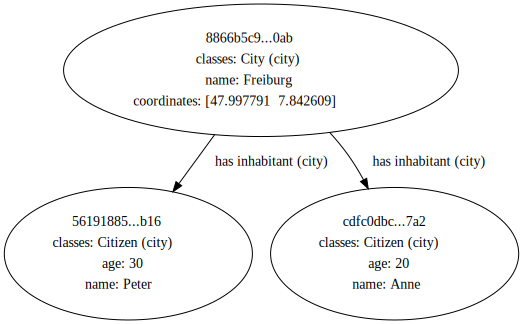

In [4]:
from simphony_osp.namespaces import city
from simphony_osp.tools import semantic2dot

with sqlite:
    freiburg = city.City(name="Freiburg", coordinates=[47.997791, 7.842609])
    peter = city.Citizen(name="Peter", age=30)
    anne = city.Citizen(name="Anne", age=20)
    freiburg[city.hasInhabitant] += peter, anne
    
semantic2dot(sqlite)

To confirm the set of changes that have been performed, it is necessary to "commit" them. Remember that **uncommitted changes are lost** after closing the session or the Python shell.

In [5]:
sqlite.commit()

After the job is done, the session should be "closed" to free the resource that is being used. In the SQLite case, to close the database file.

In [6]:
sqlite.close()

The city and its citizens have been successfully saved to the database file. If the wrapper is used to reopen the database, the saved individuals will be available in the resulting session object.

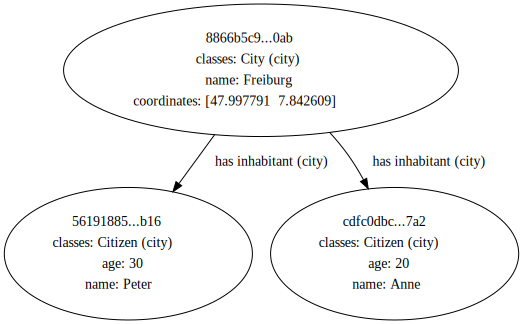

In [7]:
from IPython.display import display

with SQLite('database.db', True) as sqlite:
    display(semantic2dot(sqlite))

Wrappers sessions that interact with simulation engines have an additional method, `compute`, that commits the uncommitted data, executes the simulation and updates the session to reflect the new status of the individuals involved. Depending on the wrapper, the `compute` method may accept keyword arguments. The [quickstart](../../introduction/quickstart.ipynb#Wrappers) tutorial demonstrates the use of the `compute` method with the [SimLAMMPS](https://github.com/simphony/simphony-osp-simlammps) wrapper, as well as how transfer of ontology individuals between different wrappers, which is done in exactly the same way as [between sessions](../sessions/management.ipynb). 